# BiT Image Classificaiton Model Quantiziation pipeline with NNCF

This tutorial demonstrates the Quantization of the BiT Image Classification model, which is fine-tuned on the Imagentte dataset with 10 class labels with [NNCF](https://github.com/openvinotoolkit/nncf). It uses [BiT-M-R50x1/1](https://www.kaggle.com/models/google/bit/frameworks/tensorFlow2/variations/m-r50x1/versions/1?tfhub-redirect=true) model, which is trained on ImageNet-21k. Big Transfer (BiT) is a recipe for pre-training image classification models on large supervised datasets and efficiently fine-tuning them on any given target task. The recipe achieves excellent performance on a wide variety of tasks, even when using very few labeled examples from the target dataset. This tutorial uses OpenVINO backend for performing model quantization in NNCF.

This tutorial consists of the following steps:
-   Prepare Dataset.
-   Plotting data samples.
-   Model fine-tuning.
-   Perform the model optimization (IR) step.
-   Compute model accuracy of the TF model.
-   Compute model accuracy of the optimized model.
-   Run nncf.Quantize for getting an Optimized model.
-   Compute model accuracy of the quantized model.
-   Compare the model accuracy of the optimized and quantized models.
-   Compare inference results on one picture


In [1]:
import sys
import importlib.util

%pip install -q "openvino>=2023.1.0" "nncf==2.4.0" "tensorflow-hub>=0.15.0" "tensorflow_datasets"

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, sys
import numpy as np
from pathlib import Path 

from openvino.runtime import Core
import openvino as ov
import nncf
import logging

sys.path.append("../utils")
from notebook_utils import download_file
from nncf.common.logging.logger import set_log_level
set_log_level(logging.ERROR)

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow import keras

from PIL import Image
from sklearn.metrics import accuracy_score

2023-12-20 10:08:26.593960: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-20 10:08:26.597084: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-20 10:08:26.639774: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 10:08:26.639809: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 10:08:26.639838: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

[ WARNING ] /home/psakhamo/miniconda3/envs/big_transfer_ipynb/lib/python3.11/site-packages/openvino/tools/accuracy_checker/preprocessor/launcher_preprocessing/ie_preprocessor.py:21: FutureWarning: OpenVINO Inference Engine Python API is deprecated and will be removed in 2024.0 release.For instructions on transitioning to the new API, please refer to https://docs.openvino.ai/latest/openvino_2_0_transition_guide.html
  from openvino.inference_engine import ResizeAlgorithm, PreProcessInfo, ColorFormat, MeanVariant  # pylint: disable=import-outside-toplevel,package-absolute-imports

[ WARNING ] /home/psakhamo/miniconda3/envs/big_transfer_ipynb/lib/python3.11/site-packages/openvino/tools/accuracy_checker/launcher/dlsdk_launcher.py:60: FutureWarning: OpenVINO nGraph Python API is deprecated and will be removed in 2024.0 release.For instructions on transitioning to the new API, please refer to https://docs.openvino.ai/latest/openvino_2_0_transition_guide.html
  import ngraph as ng



Post-training Optimization Tool is deprecated and will be removed in the future. Please use Neural Network Compression Framework instead: https://github.com/openvinotoolkit/nncf
Nevergrad package could not be imported. If you are planning to use any hyperparameter optimization algo, consider installing it using pip. This implies advanced usage of the tool. Note that nevergrad is compatible only with Python 3.8+


INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


Parameter initializations

In [3]:
ie = Core()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# For top 5 labels.
MAX_PREDS = 1
TRAINING_BATCH_SIZE = 128
BATCH_SIZE = 1
IMG_SIZE = (256, 256)  # Default Imagenet image size
NUM_CLASSES = 10  # For Imagenette dataset
FINE_TUNING_STEPS = 1
LR = 1e-5

MEAN_RGB = (0.485 * 255, 0.456 * 255, 0.406 * 255)  # From Imagenet dataset
STDDEV_RGB = (0.229 * 255, 0.224 * 255, 0.225 * 255)  # From Imagenet dataset


### Prepare Dataset

In [4]:
datasets, datasets_info = tfds.load('imagenette/160px', shuffle_files=True, as_supervised=True, with_info=True,
                                    read_config=tfds.ReadConfig(shuffle_seed=0))
train_ds, validation_ds = datasets['train'], datasets['validation']


In [5]:

def preprocessing(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


train_dataset = (train_ds.map(preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                              .batch(TRAINING_BATCH_SIZE)
                              .prefetch(tf.data.experimental.AUTOTUNE))

validation_dataset = (validation_ds.map(preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                        .batch(TRAINING_BATCH_SIZE)
                                        .prefetch(tf.data.experimental.AUTOTUNE))

Class labels of Imagentte dataset

In [6]:
# Label dictionary with imagenette sample names and classes
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

# Imagenette samples name index
class_idx_dict = ['n01440764', 'n02102040', 'n02979186', 'n03000684', \
                  'n03028079', 'n03394916', 'n03417042', 'n03425413', \
                  'n03445777', 'n03888257']

def label_func(key):
    return lbl_dict[key]

### Plotting data samples

2023-12-20 10:08:31.764221: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


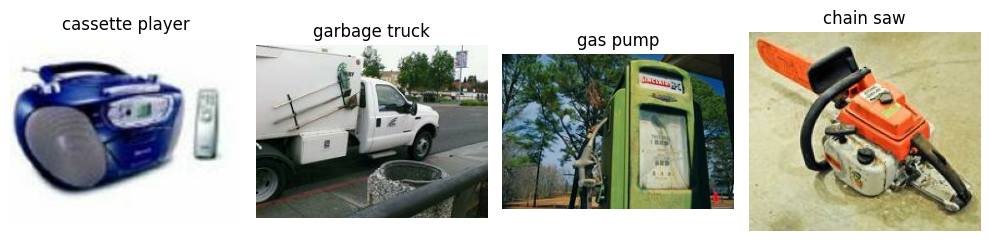

In [7]:
import matplotlib.pyplot as plt

# Get the class labels from the dataset info
class_labels = datasets_info.features['label'].names

# Display labels along with the examples
num_examples_to_display = 4
fig, axes = plt.subplots(nrows=1, ncols=num_examples_to_display, figsize=(10, 5))  # Adjust figsize as needed

for i, (image, label_index) in enumerate(train_ds.take(num_examples_to_display)):
    label_name = class_labels[label_index.numpy()]

    axes[i].imshow(image.numpy())
    axes[i].set_title(f"{label_func(label_name)}")
    axes[i].axis('off')
    plt.tight_layout()
plt.show()

2023-12-20 10:08:32.924487: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


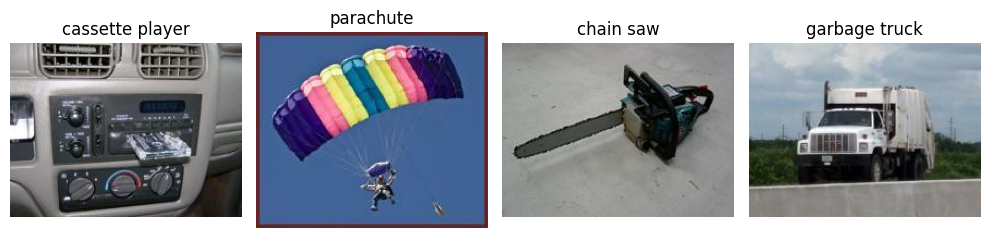

In [8]:
import matplotlib.pyplot as plt

# Get the class labels from the dataset info
class_labels = datasets_info.features['label'].names

# Display labels along with the examples
num_examples_to_display = 4
fig, axes = plt.subplots(nrows=1, ncols=num_examples_to_display, figsize=(10, 5)) # Adjust figsize as needed

for i, (image, label_index) in enumerate(validation_ds.take(num_examples_to_display)):
    label_name = class_labels[label_index.numpy()]

    axes[i].imshow(image.numpy())
    axes[i].set_title(f"{label_func(label_name)}")
    axes[i].axis('off')
    plt.tight_layout()
plt.show()

### Model Fine-tuning

In [9]:
# Load the BiT model
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_m = hub.KerasLayer(bit_model_url, trainable=True)

# Customize the model for the new task
model = tf.keras.Sequential([
    bit_m,
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
model.fit(train_dataset.take(5000),
          epochs=FINE_TUNING_STEPS,
          validation_data=validation_dataset.take(2000))
model.save("./bit_tf_model/", save_format='tf')

KeyboardInterrupt: 

### Perform model optimization (IR) step

In [ ]:
ir_path = Path("./bit_ov_model/bit_m_r50x1_1.xml")
if not ir_path.exists():
    print("Initiating model optimization..!!!")
    ov_model = ov.convert_model("./bit_tf_model")
    ov.save_model(ov_model, ir_path)
else:
    print(f"IR model {ir_path} already exists.")
   

### Compute model accuracy of the TF model

In [ ]:
tf_model = tf.keras.models.load_model("./bit_tf_model/")
   
tf_predictions = []
gt_label = []

for _, label in validation_dataset:
    for l in label:
        l_list = l.numpy().tolist()
        gt_label.append(l_list.index(1))
        
for img_batch, label_batch in validation_dataset:
    tf_result_batch = tf_model.predict(img_batch, verbose=0)
    for i in range(len(img_batch)):
        tf_result = tf_result_batch[i]
        tf_result = tf.reshape(tf_result, [-1])
        top5_label_idx = np.argsort(tf_result)[-MAX_PREDS::][::-1]
        tf_predictions.append(top5_label_idx)

# Convert the lists to NumPy arrays for accuracy calculation
tf_predictions = np.array(tf_predictions)
gt_label = np.array(gt_label)

tf_acc_score = accuracy_score(tf_predictions, gt_label)


### Compute model accuracy of the optimized model

In [ ]:
ov_fp32_model = ie.read_model("./bit_ov_model/bit_m_r50x1_1.xml")
ov_fp32_model.reshape([1, IMG_SIZE[0], IMG_SIZE[1], 3])

# Target device set to CPU (Other options Ex: AUTO/GPU/dGPU/)
compiled_model = ov.compile_model(ov_fp32_model)
output = compiled_model.outputs[0]

ov_predictions = []
for img_batch, _ in validation_dataset:
    for image in img_batch:
        image = tf.expand_dims(image, axis=0)
        pred = compiled_model(image)[output]
        ov_result = tf.reshape(pred, [-1])
        top_label_idx = np.argsort(ov_result)[-MAX_PREDS::][::-1]
        ov_predictions.append(top_label_idx)

fp32_acc_score = accuracy_score(ov_predictions, gt_label)


### Run nncf.Quantize for getting an Optimized Model 

BiT OpenVINO (IR) Model Quantization using NNCF

1. Preprocessing and Preparing validatiaon samples for NNCF claibration
2. Perform NNCF Quantization on OpenVINO FP32 model
3. Serialize Quantized OpenVINO INT8 model

In [ ]:
def nncf_preprocessing(image, label):
  image = tf.image.resize(image, IMG_SIZE)
  image = image - MEAN_RGB
  image = image / STDDEV_RGB
  return image

val_ds = (validation_ds.map(nncf_preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                        .batch(1)
                                        .prefetch(tf.data.experimental.AUTOTUNE))

calibration_dataset = nncf.Dataset(val_ds)
    
ov_fp32_model = ie.read_model("./bit_ov_model/bit_m_r50x1_1.xml")

ov_int8_model = nncf.quantize(ov_fp32_model, calibration_dataset, fast_bias_correction=False)

ov.serialize(ov_int8_model, "./bit_ov_int8_model/bit_m_r50x1_1_ov_int8.xml")

### Compute model accuracy of the quantized model

In [ ]:
nncf_quantized_model = ie.read_model("./bit_ov_int8_model/bit_m_r50x1_1_ov_int8.xml")
nncf_quantized_model.reshape([1, IMG_SIZE[0], IMG_SIZE[1], 3])

# Target device set to CPU by default
compiled_model = ov.compile_model(nncf_quantized_model)
output = compiled_model.outputs[0]

ov_predictions = []
inp_tensor = nncf_quantized_model.inputs[0]
out_tensor = nncf_quantized_model.outputs[0]
        
for img_batch, _ in validation_dataset:
    for image in img_batch:
        image = tf.expand_dims(image, axis=0)
        pred = compiled_model(image)[output]
        ov_result = tf.reshape(pred, [-1])
        top_label_idx = np.argsort(ov_result)[-MAX_PREDS::][::-1]
        ov_predictions.append(top_label_idx)
        
int8_acc_score = accuracy_score(ov_predictions, gt_label)


### Compare model accuraacy of the optimized and quantized models

In [ ]:
print(f"Accuracy of the tensorflow model (fp32): {tf_acc_score * 100: .2f}%")
print(f"Accuracy of the OpenVINO optimized model (fp32): {fp32_acc_score * 100: .2f}%")
print(f"Accuracy of the OpenVINO quantized model (int8): {int8_acc_score * 100: .2f}%")
accuracy_drop = fp32_acc_score - int8_acc_score
print(f"Accuracy drop between OV FP32 and INT8 model: {accuracy_drop * 100:.1f}% ")

### Compare inference results on one picture 

In [ ]:

# Accessing validation sample
sample_idx = 50
vds = datasets['validation']

if len(vds) > sample_idx:
    sample = vds.take(sample_idx + 1).skip(sample_idx).as_numpy_iterator().next()
else:
    print("Dataset does not have enough samples...!!!")

# Image data
sample_data = sample[0]

# Label info
sample_label = sample[1]

# Image data pre-processing
image = tf.image.resize(sample_data, IMG_SIZE)
image = tf.expand_dims(image, axis=0)
image = tf.cast(image, tf.float32) / 255.0

# OpenVINO inference 
def ov_inference(model: ov.Model, image) -> str:
    compiled_model = ov.compile_model(model)
    output = compiled_model.outputs[0]
    pred = compiled_model(image)[output]
    ov_result = tf.reshape(pred, [-1])
    pred_label = np.argsort(ov_result)[-MAX_PREDS::][::-1]
    return pred_label

# OpenVINO FP32 model
ov_fp32_model = ie.read_model("./bit_ov_model/bit_m_r50x1_1.xml")
ov_fp32_model.reshape([1, IMG_SIZE[0], IMG_SIZE[1], 3])

# OpenVINO INT8 model
ov_int8_model = ie.read_model("./bit_ov_int8_model/bit_m_r50x1_1_ov_int8.xml")
ov_int8_model.reshape([1, IMG_SIZE[0], IMG_SIZE[1], 3])

# OpenVINO FP32 model inference
ov_fp32_pred_label = ov_inference(ov_fp32_model, image)

print(f"Predicted label for the sample picture by float (fp32) model: {label_func(class_idx_dict[int(ov_fp32_pred_label)])}\n")

# OpenVINO FP32 model inference
ov_int8_pred_label = ov_inference(ov_int8_model, image)
print(f"Predicted label for the sample picture by qunatized (int8) model: {label_func(class_idx_dict[int(ov_int8_pred_label)])}\n")

# Plotting the image sample with ground truth
plt.figure()
plt.imshow(sample_data)
plt.title(f"Ground truth: {label_func(class_idx_dict[sample_label])}")
plt.axis('off')
plt.show()
